### Importing Libraries

In [20]:
# import libraries
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

### Reading in Data

In [2]:
# read in data using read_csv
df = pd.read_csv('wiki_train.csv')
df.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


### Cleaning data

In [3]:
# function to clean data
def clean_text_data(text_data):
    # removing ip address and normalising casing
    text_data = [re.sub('[\d+\.{3}]\d+',"",comment.lower()) for comment in text_data]

    # removing URLs
    text_data = [re.sub('\w+://\S+','',comment) for comment in text_data]

    # removing \r and \n
    text_data = [re.sub(r'[\n\r]','',comment) for comment in text_data]
    df.head()

    # removing \'
    text_data = [comment.replace("\'","") for comment in text_data]

    # performing word tokenization
    text_data = [word_tokenize(comment) for comment in text_data]

    
    comments_stopwords = stopwords.words('english')
    comments_punctuations = list(punctuation)
    stopwords_punctuations = comments_stopwords + comments_punctuations + ["''","...","``","===="]
    
    # function to remove stopwords and punctuations
    def remove_stopwords(tokenized_comments):
        return [tokens for tokens in tokenized_comments if tokens not in stopwords_punctuations]
    
    # removing stop words and punctuations
    text_data = [remove_stopwords(comment) for comment in text_data]
    
    return text_data



# cleaning comment_text column for training data
df['comment_text'] = clean_text_data(df['comment_text'])
df.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"[barnstar, defender, wiki, barnstar, like, edi...",0
1,9250cf637294e09d,"[seems, unbalanced, whatever, said, mathsci, s...",0
2,ce1aa4592d5240ca,"[marya, dzmitruk, born, minsk, belarus, march,...",0
3,48105766ff7f075b,"[talkback, dear, celestia]",0
4,0543d4f82e5470b6,"[new, categories, honestly, think, need, add, ...",0


### Using Counter to find top items in data

In [4]:
# using counter to find top items in data
merged_token_list = []
for tokens in df['comment_text']:
    merged_token_list.extend(tokens)

counter_list = Counter(merged_token_list)
counter_list.most_common(16)

[('article', 1620),
 ('page', 1448),
 ('wikipedia', 1303),
 ('talk', 1171),
 ('please', 1003),
 ('ass', 985),
 ('would', 961),
 ('fuck', 903),
 ('one', 851),
 ('like', 832),
 ('dont', 775),
 ('also', 640),
 ('think', 628),
 ('see', 626),
 ('know', 595),
 ('edit', 557)]

In [5]:
# removing top 5 most common words
common_words = ['article','page','wikipedia','talk','please']

# function to remove words
def remove_words(tokenized_comments):
        return [tokens for tokens in tokenized_comments if tokens not in common_words]

final_tokens = [remove_words(word) for word in df['comment_text'] if word not in common_words]
final_tokens = [" ".join(word_list) for word_list in final_tokens]

### Separating into Train and Test sets

In [6]:
# obtaining X and y values
X = final_tokens
y = df['toxic'].values

# spliting data into training and testing datasets
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42)

### Applying Tf-idf

In [7]:
# applying tf-idf
tfidfVec = TfidfVectorizer(max_features = 4000, ngram_range=(1,2))
xtrain_trans = tfidfVec.fit_transform(xtrain)
xtest_trans = tfidfVec.transform(xtest)

### Support Vector Machine Model

In [8]:
# creating SVC estimator
svm_model = SVC(kernel='linear')

# fit training data
svm_model.fit(xtrain_trans,ytrain)

# predict using training data
ypred_train = svm_model.predict(xtrain_trans)

# predict using test data
ypred_test = svm_model.predict(xtest_trans)

# model evaluation (Accuracy, Recall and F1)
print(classification_report(ytrain,ypred_train))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3196
           1       0.99      0.64      0.78       304

    accuracy                           0.97      3500
   macro avg       0.98      0.82      0.88      3500
weighted avg       0.97      0.97      0.97      3500



The f1 score is relatively low for label '1'. This is due to the class imbalance, which can be seen in the 'support' column of the classification report.

### Asjusting class imbalance

In [9]:
# adjusted (balanced) svm model
svm_balanced = SVC(kernel='linear',class_weight='balanced',random_state=42)

# fit training data
svm_balanced.fit(xtrain_trans,ytrain)

# predict using training data
ypred_train = svm_balanced.predict(xtrain_trans)

# predict using test data
ypred_test = svm_balanced.predict(xtest_trans)

# model evaluation (Accuracy, Recall and F1)
print(classification_report(ytrain,ypred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3196
           1       0.88      0.98      0.93       304

    accuracy                           0.99      3500
   macro avg       0.94      0.99      0.96      3500
weighted avg       0.99      0.99      0.99      3500



### Hyperparameter tuning

In [10]:
# create dictionary for grid parameters
grid_parameters = {'C':[0.1,1,10,100,1000,10000,100000]}
# values = np.logspace(-4,2,10)
# grid_parameters = {'C': values}
# creating gridSearch model
grid_search = GridSearchCV(estimator = svm_balanced, param_grid = grid_parameters,
                           cv = StratifiedKFold(5), n_jobs = -1,verbose = 0, scoring = 'recall')

# fitting data to gridSearch model
grid_search.fit(xtrain_trans,ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', kernel='linear',
                           random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000, 100000]},
             scoring='recall')

In [11]:
# retrieving best estimator parameters
grid_search.best_estimator_

SVC(C=1000, class_weight='balanced', kernel='linear', random_state=42)

### Predicting test values with best estimator

In [12]:
# predicting test data using best estimator
ypred_test = grid_search.best_estimator_.predict(xtest_trans)

# model evaluation (Accuracy, Recall and F1)
print(classification_report(ytest,ypred_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1367
           1       0.33      0.67      0.44       133

    accuracy                           0.85      1500
   macro avg       0.65      0.77      0.68      1500
weighted avg       0.91      0.85      0.87      1500



### Most prominent terms in toxic comments

In [13]:
# extracting toxic comments where ypred_test == 1 is True
toxic_comments = pd.Series(xtest)[ypred_test == 1].values

# using counter to find top words in data
toxic_counter_list = []
for comment in toxic_comments:
    toxic_counter_list.extend(word_tokenize(comment))
    
toxic_word_count = Counter(toxic_counter_list)

toxic_word_count.most_common(15)

[('nigger', 184),
 ('die', 157),
 ('jim', 157),
 ('wales', 156),
 ('must', 156),
 ('cuntbag', 126),
 ('fucking', 94),
 ('hate', 83),
 ('jews', 80),
 ('niggers', 79),
 ('spics', 79),
 ('minoritiesi', 79),
 ('dont', 23),
 ('go', 18),
 ('like', 17)]

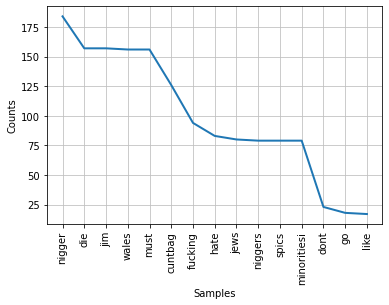

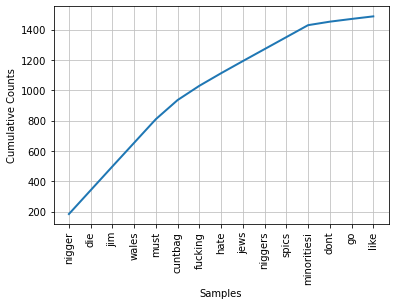

In [21]:
# plotting most common words
fdist_toxic = FreqDist(toxic_word_count)
fdist_toxic.plot(15)
plt.show()
fdist_toxic.plot(15,cumulative=True)
plt.show()